In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [3]:
def hist_means(x_data, y_data, bins):
    bin_means = np.zeros(len(bins)-1)
    for i in np.arange(len(bins)-1):
        left_edge = bins[i]
        right_edge = bins[i+1]
        count = 0
        summed = 0
        if right_edge != bins[-1]:
            masked = y_data[(x_data >= left_edge) & (x_data < right_edge)]
        else:
            masked = y_data[(x_data >= left_edge) & (x_data <= right_edge)]
        if len(masked) == 0:
            bin_means[i] = np.nan
        else:
            bin_means[i] = np.mean(masked)
    return bin_means


def hist_plotter(values, bins, labelname = '_ignore', loglog=False):
    x_plot_list = []
    y_plot_list = []
    for i in np.arange(len(bins)-1):
        left_edge = bins[i]
        right_edge = bins[i+1]
        x_plot_list.append(left_edge)
        x_plot_list.append(right_edge)
        # Nog delen door de breedte van de bins? --> Maakt het verschil voor nu alleen maar groter
        # binwidth = right_edge-left_edge
        y_plot_list.append(values[i])  # /binwidth)
        y_plot_list.append(values[i])  # /binwidth)
    if loglog == True:
        plt.loglog(x_plot_list, y_plot_list, label=labelname)
    elif loglog == False:
        plt.plot(x_plot_list, y_plot_list, label=labelname, color = 'red')
    plt.legend()
    return


def minmaxrange(dataset, length = 101):
    return np.linspace(np.min(dataset), np.max(dataset), length)

def mean_plotter(x_data, y_data):
    bins = minmaxrange(x_data)
    means = hist_means(x_data, y_data, bins)
    hist_plotter(means, bins)
    return

In [4]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

giants
Number of stars in selected sample: 23789


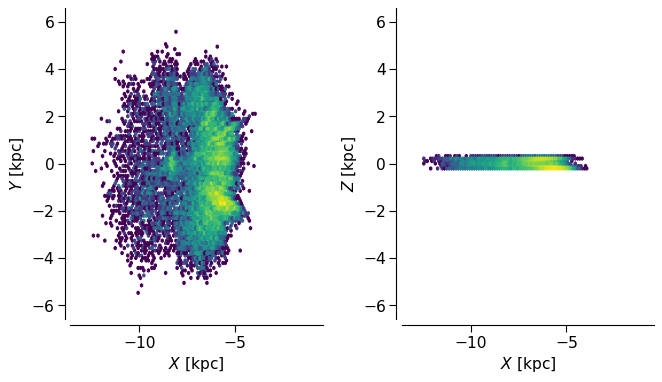

In [30]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250
# Added filter:
pmb_sn = np.abs(fgkmtable['pml']/fgkmtable['pml_error'])
pmb_sn_filter = pmb_sn > 0  # 10
#

sample_filter_init = pmb_sn_filter & plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars

filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)


print(fit_save_location[-len(filter_of_choice):])

###

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


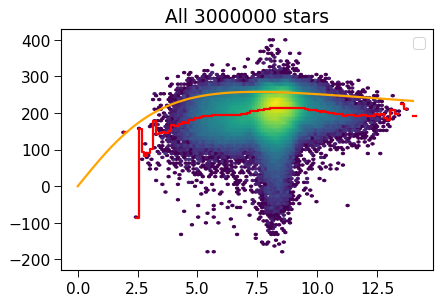

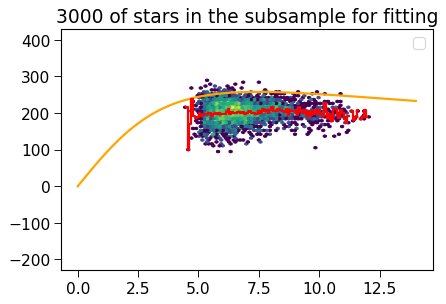

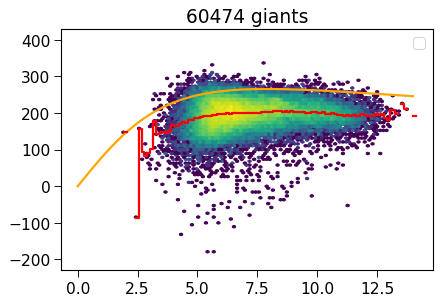

In [17]:
# Plotting the distribution of V_phi for the entire dataset.
plt.hexbin(fgkmtable['R_gc'][no_spt_filter]/1000, fgkmtable['v_phi_gc'][no_spt_filter], bins='log', mincnt=1, extent=[14, 1, -200, 400])
plt.title("All {} stars".format(len(fgkmtable['R_gc'][no_spt_filter])))
mean_plotter(np.array(fgkmtable['R_gc'])/1000, np.array(fgkmtable['v_phi_gc']))
# mincnt=1, , extent=plotgrid

def bp_function(r, p_param, h_param):
    rotcur = lambda x : x/h_param * np.power(1 + (x/h_param)**2, (p_param-2)/4)
    v0 = 404.0  #km/s
    vc = v0*rotcur(r)
    return v0 * r/h_param * np.power(1 + (r/h_param)**2, (p_param-2)/4)

r = np.linspace(0, 14, 1400)

p_plot = -0.9
h_plot = 5

plt.plot(r, bp_function(r, p_plot, h_plot), color='orange')

plt.figure()
plt.title("{} of stars in the subsample for fitting".format(len(fgkm_subsample['R_gc'])))
plt.hexbin(fgkm_subsample['R_gc']/1000, fgkm_subsample['v_phi_gc'], bins='log', mincnt=1, extent=[14, 1, -200, 400])
plt.plot(r, bp_function(r, p_plot, h_plot), color='orange')
mean_plotter(np.array(fgkm_subsample['R_gc'])/1000, np.array(fgkm_subsample['v_phi_gc']))

plt.figure()
plt.title("{} giants".format(len(fgkmtable['R_gc'][giants])))
plt.hexbin(fgkmtable['R_gc'][giants]/1000, fgkmtable['v_phi_gc'][giants], bins='log', mincnt=1, extent=[14, 1, -200, 400])
plt.plot(r, bp_function(r, p_plot+0.1, h_plot), color='orange')
mean_plotter(np.array(fgkmtable['R_gc'][giants])/1000, np.array(fgkmtable['v_phi_gc'][giants]))


Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


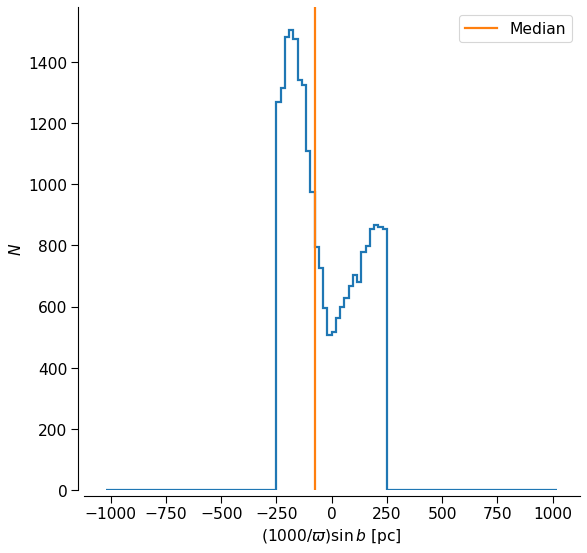

In [31]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [19]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()

vdisp_function_bp2_4 = {'stanfile':'stanfiles/rotcurve-bp2_4.stan',
                'npars': 12,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':5.0, 'p_param':-0.5, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':400.0, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }

vdisp_function_bp2_4_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_4_nov0.stan',
                'npars': 11,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':5.0, 'p_param':-0.5, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }

    
bp2010_model = {'stanfile':'stanfiles/mwdisk-bp2010-model.stan', 
               'npars':9,
               'parnames':['Vcirc_sun', 'hbp', 'pbp', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispR', 'vdispPhi', 'vdispZ'],
               'labels':[r'$V_{\mathrm{circ},\odot}}$', r'$h$', r'$p$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,R}$', r'$\sigma_{v,\phi}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'hbp':4.0, 'pbp':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispR':10.0, 'vdispPhi':10.0, 'vdispZ':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'hbp':np.nan, 'pbp':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 
                              'vdispR':np.nan, 'vdispPhi':np.nan, 'vdispZ':np.nan}
              }

stan_model = bp2010_model



Number of sources in sample: 3000


In [20]:
fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0')) # Needs to be replaced with cmdstan location on other Windows devices
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500    
nsampling = 1000
nchains = 4    

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fgkm_fit = fgkm_model.sample(show_console=False, chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook', output_dir=fit_save_location)

# https://mc-stan.org/cmdstanr/reference/model-method-sample.html 

19:12:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:33:47 - cmdstanpy - INFO - CmdStan done processing.
19:33:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: mwdisk_bp2010_model_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/mwdisk-bp2010-model.stan', line 183, column 2 to column 21)
	Exception: mwdisk_bp2010_model_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/mwdisk-bp2010-model.stan', line 183, column 2 to column 21)
	Exception: mwdisk_bp2010_model_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/mwdisk-bp2010-model.stan', line 183, column 2 to column 21)
	Exception: mwdisk_bp2010_model_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/

In [21]:
import winsound
frequency = 1000
duration = 1500  # ms
winsound.Beep(frequency, duration)

In [32]:
fgkm_fit.diagnose()

'Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\mwdisk-bp2010-model-20230528191229_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\mwdisk-bp2010-model-20230528191229_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\mwdisk-bp2010-model-20230528191229_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\mwdisk-bp2010-model-20230528191229_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detec

In [22]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)

fgkm_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

KeyboardInterrupt: 

In [23]:
# 3000 giants
print(fit_save_location[-6:])
fgkm_fit.summary()[0:stan_model['npars']+6]

giants


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-9250.390000,0.052027,2.138130,-9254.360000,-9250.100000,-9247.480000,1688.95,0.857496,1.001920
Vcirc_sun,234.310000,0.634257,48.567300,153.776000,234.200000,313.582000,5863.50,2.976960,0.999244
hbp,4.012200,0.014095,0.971241,2.424160,3.994790,5.607220,4748.28,2.410750,1.000140
pbp,0.617036,0.009915,0.863139,-0.809472,0.699950,1.877630,7577.70,3.847270,0.999196
Vsun_pec_x,25.101200,0.019332,1.736450,22.253800,25.082300,27.953700,8067.95,4.096180,0.999446
Vsun_pec_y,48.904200,0.014081,1.057000,47.151700,48.874200,50.698000,5634.82,2.860850,1.000410
Vsun_pec_z,8.845500,0.004427,0.380341,8.227050,8.851650,9.458840,7380.02,3.746910,0.999581
vdispR,78.074000,0.019314,1.386610,75.841600,78.055100,80.403400,5154.31,2.616890,0.999443
vdispPhi,30.305600,0.013136,0.894210,28.861900,30.294400,31.811500,4633.86,2.352650,0.999970
vdispZ,20.400300,0.003162,0.277084,19.954400,20.397700,20.848700,7679.54,3.898980,0.999424


Vcirc_sun = 234.1+48.5-48.2
hbp = 4.0+1.0-0.9
pbp = 0.7+0.9-1.1
Vsun_pec_x = 25.1+1.8-1.7
Vsun_pec_y = 48.9+1.1-1.0
Vsun_pec_z = 8.9+0.4-0.4
vdispR = 78.1+1.4-1.4
vdispPhi = 30.3+0.9-0.9
vdispZ = 20.4+0.3-0.3


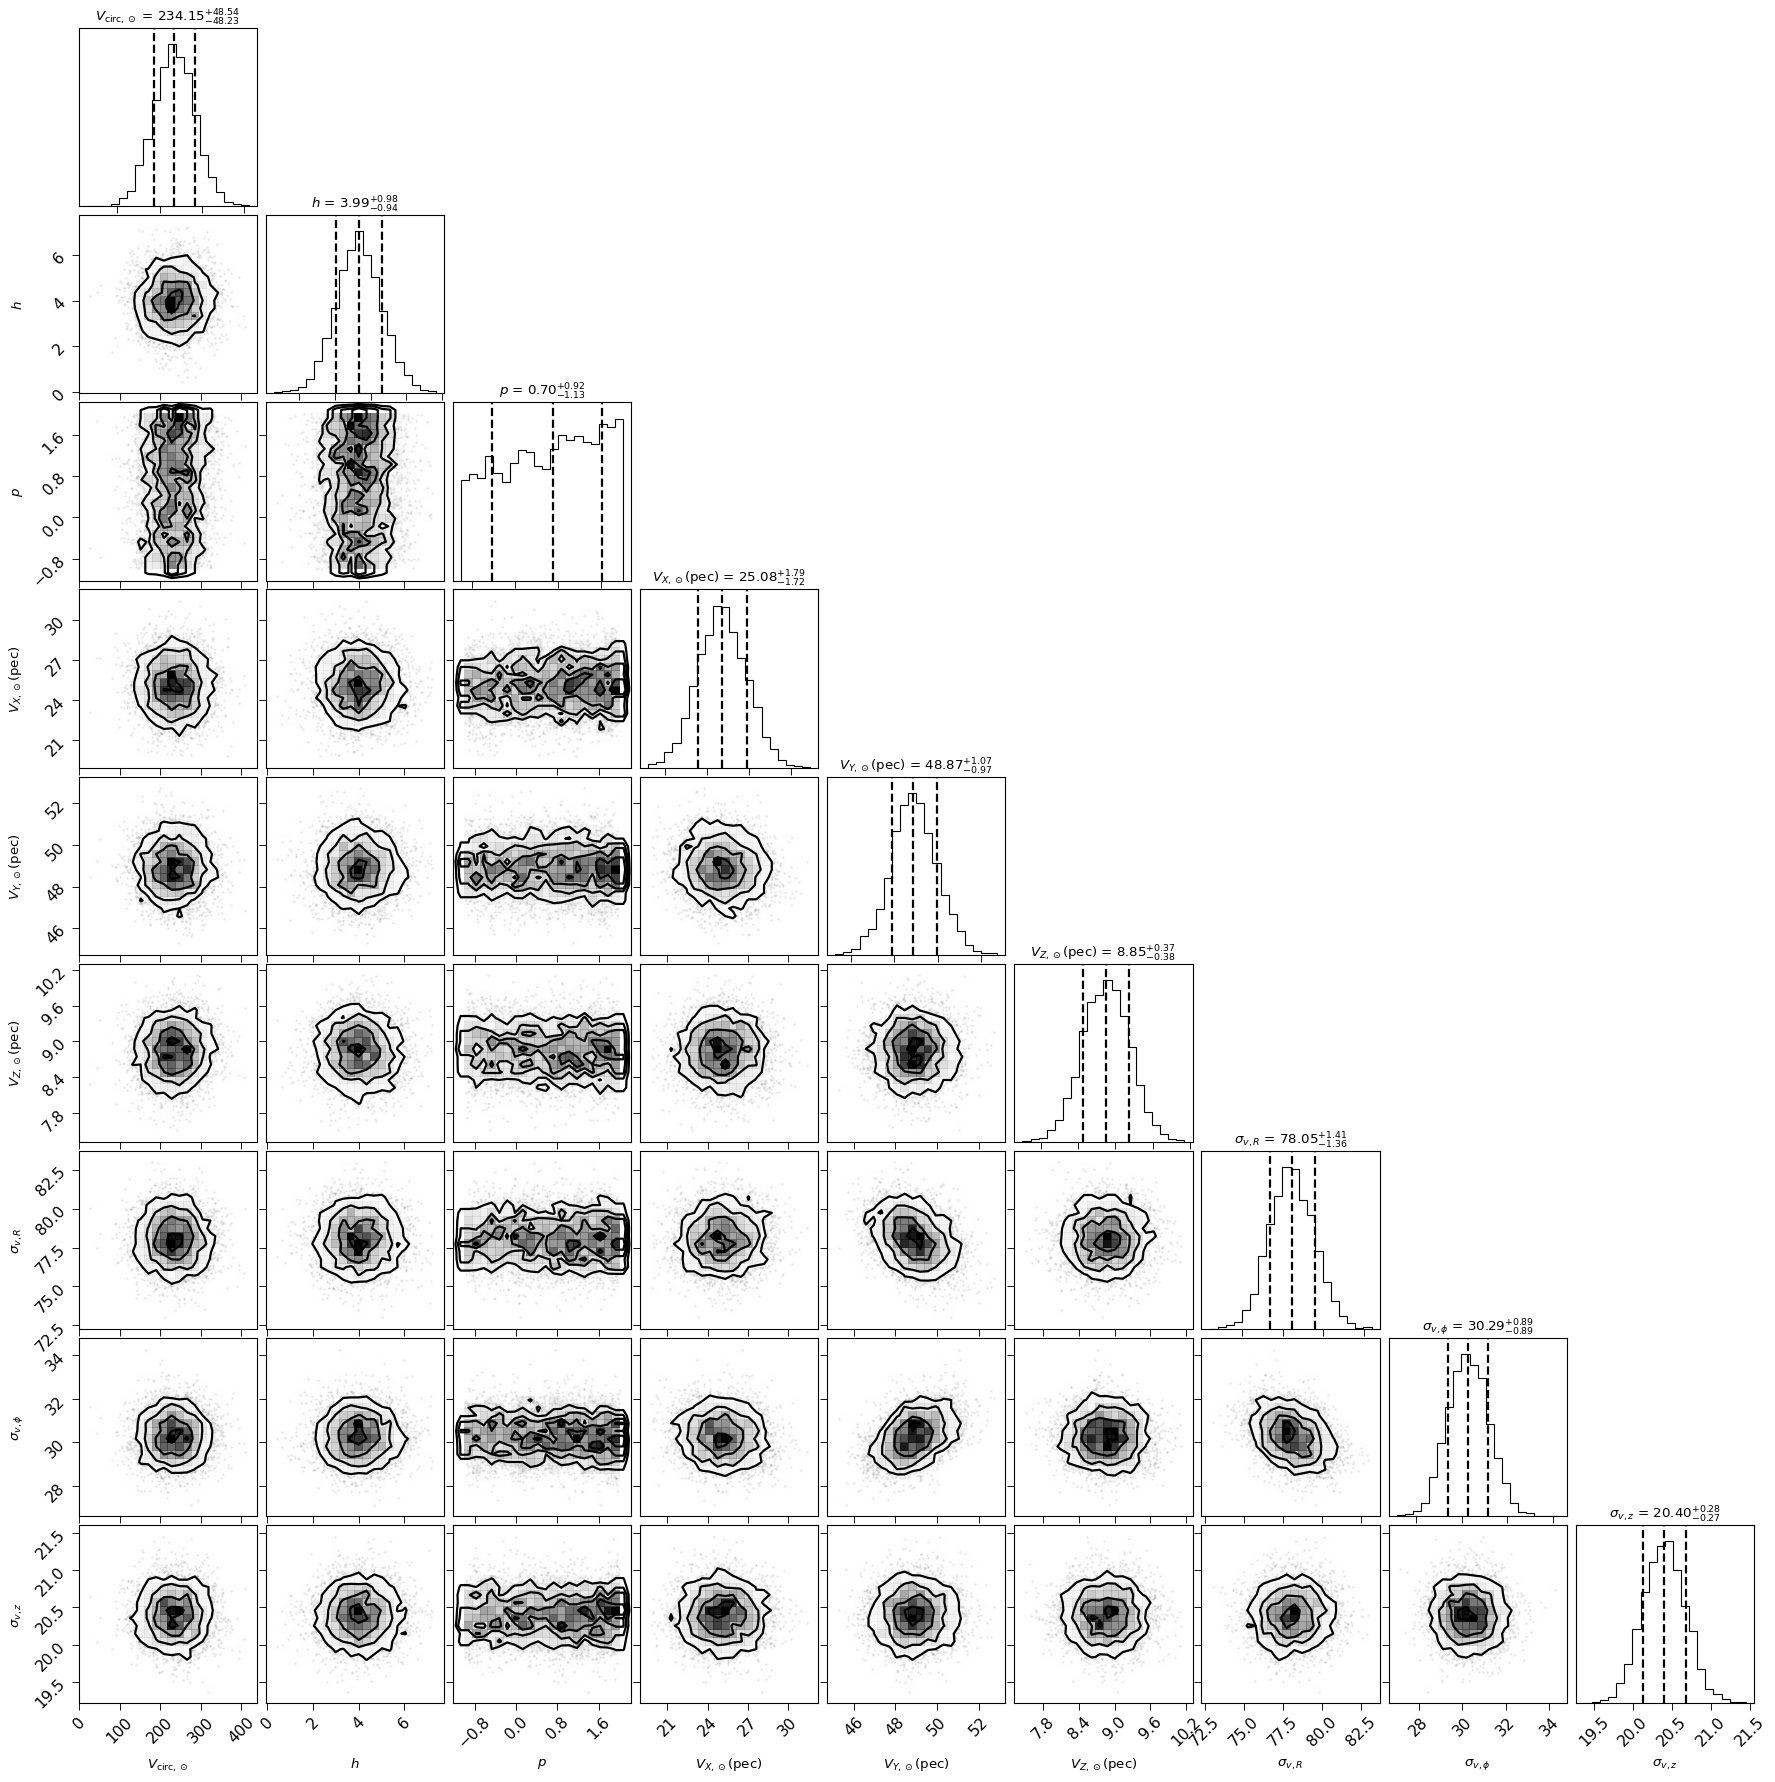

In [24]:
# 300 giants
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

range_number = 7  # Do not change!
sample_lists = []
for i, par in zip(range(range_number, range_number+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
# plt.show()

now = datetime.now()
moment_time = now.strftime("%d_%m_%Y__%H_%M_%S")
# plt.savefig('img/Cornerplot_{}.png'.format(moment_time))

In [25]:
idata = az.from_cmdstanpy(
    posterior=fgkm_fit,
    posterior_predictive=['pred_pml', 'pred_pmb'],
    observed_data={'pml_obs': fgkm_data['pml_obs'],
                   'pmb_obs': fgkm_data['pmb_obs']},
    coords={'nsources': np.arange(fgkm_data['N'])},
    dims={
        'pml_obs': ['nsources'],
        'pmb_obs': ['nsources'],
        'pred_pml': ['nsources'],
        'pred_pmb': ['nsources'],
    },
)

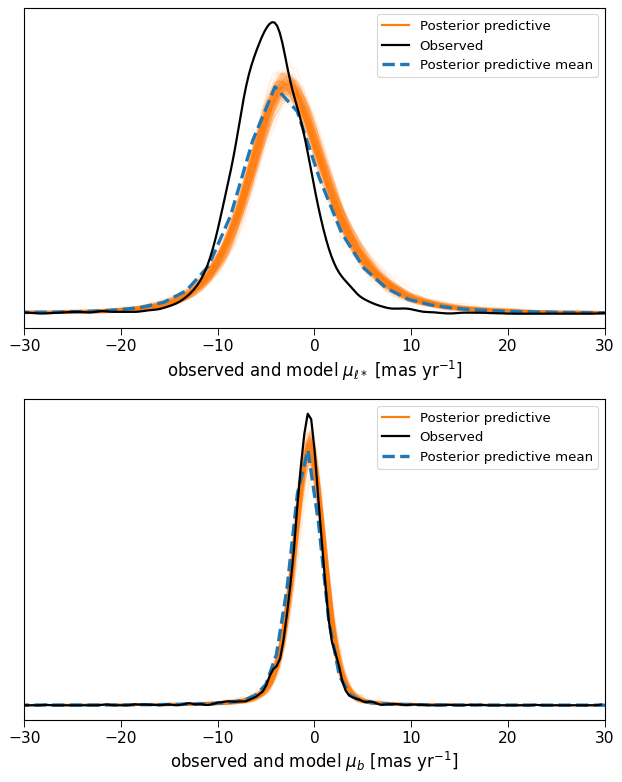

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2*5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pred_pml', 'pmb_obs':'pred_pmb'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    #apply_tufte(ax)
axes[0].set_xlim(-30,30)
axes[1].set_xlim(-30,30)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('fgkmstars_pms_posterior_predictive.png')

plt.show()

# Checking errors on proper motions

No clear outliers in errors of $\mu_l$ and $\mu_b$ detected.


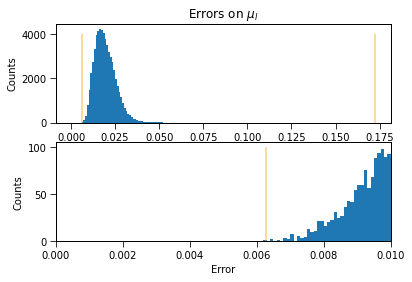

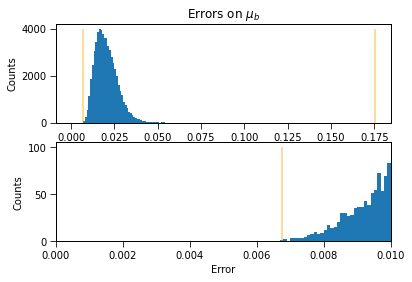

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(fgkmtable['pml_error'][giants], bins=np.linspace(0, 0.1, 101))
ax1.set_title("Errors on $\mu_l$")
ax1.set_ylabel("Counts")
ax1.vlines([np.min(fgkmtable['pml_error'][giants]), np.max(fgkmtable['pml_error'][giants])], 0, 4000, alpha = 0.4, color='orange')

ax2.hist(fgkmtable['pml_error'][giants], bins=np.linspace(0, 0.01, 101))
ax2.vlines(np.min(fgkmtable['pml_error'][giants]), 0, 100, alpha = 0.4, color='orange')
ax2.set_xlabel("Error")
ax2.set_ylabel("Counts")
plt.xlim(0, 0.010)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(fgkmtable['pmb_error'][giants], bins=np.linspace(0, 0.1, 101))
ax1.set_title("Errors on $\mu_b$")
ax1.set_ylabel("Counts")
ax1.vlines([np.min(fgkmtable['pmb_error'][giants]), np.max(fgkmtable['pmb_error'][giants])], 0, 4000, alpha = 0.4, color='orange')

ax2.hist(fgkmtable['pmb_error'][giants], bins=np.linspace(0, 0.01, 101))
ax2.set_xlabel("Error")
ax2.set_ylabel("Counts")
ax2.set_xlim(0, 0.010)
ax2.vlines(np.min(fgkmtable['pmb_error'][giants]), 0, 100, alpha = 0.4, color='orange')

print("No clear outliers in errors of $\mu_l$ and $\mu_b$ detected.")

1.9545589840261932% of pml datapoints has S/N less than 10.
9.156000926017793% of pmb datapoints has S/N less than 10.


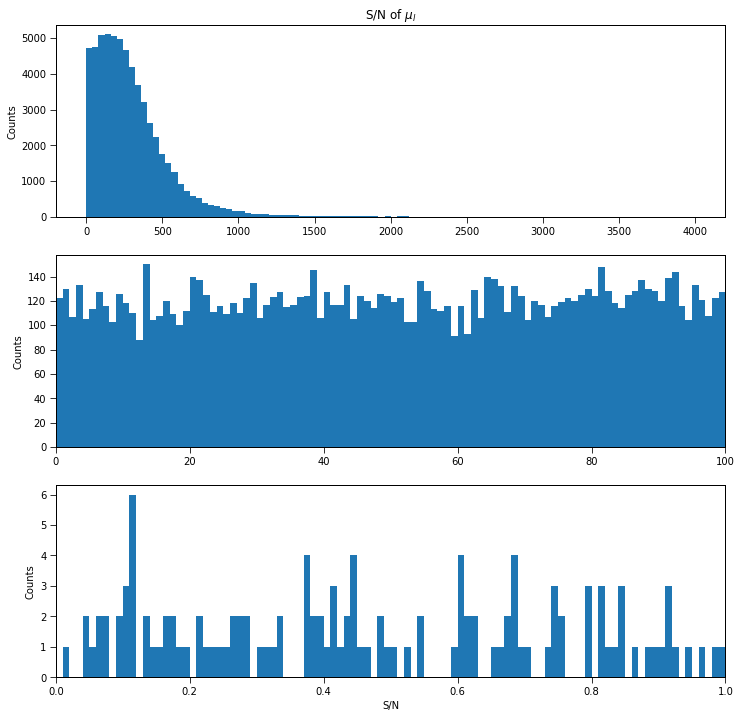

In [122]:
pml_sn = np.abs(fgkmtable['pml']/fgkmtable['pml_error'])
pmb_sn = np.abs(fgkmtable['pmb']/fgkmtable['pmb_error'])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 4*3))
ax1.hist(pml_sn[giants], bins=np.linspace(0, 4000, 101))
ax1.set_title("S/N of $\mu_l$")
ax1.set_ylabel("Counts")

ax2.hist(pml_sn[giants], bins=np.linspace(0, 100, 101))
# ax2.set_title("S/N of $\mu_l$")
ax2.set_ylabel("Counts")
ax2.set_xlim([0,100])

ax3.hist(pml_sn[giants], bins=np.linspace(0, 1, 101))
# ax3.set_title("S/N of $\mu_l$")
ax3.set_ylabel("Counts")
ax3.set_xlim([0,1])
ax3.set_xlabel("S/N")

# Adding a S/N filter for \mu_l might improve data a bit.
SN_threshhold = 10
print("{}% of pml datapoints has S/N less than {}.".format(np.sum(pml_sn[giants]<SN_threshhold)/len(pml_sn[giants])*100, SN_threshhold))

SN_threshhold = 10
print("{}% of pmb datapoints has S/N less than {}.".format(np.sum(pmb_sn[giants]<SN_threshhold)/len(pmb_sn[giants])*100, SN_threshhold))

# Filter would be:
pml_sn = np.abs(fgkmtable['pml']/fgkmtable['pml_error'])
pml_sn_filter = pml_sn > 10